# TO DO BEFORE COMPLETION

1. 
2. change colors of person/place/date/org in redacted side.
3. Change format - button clicks save changes, clear button clears all changes.
4. Doc-Term matrix allows us to compare terms across docs. 
5. Doc similarity

In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import dash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from dash.dependencies import Input, Output, State
from dash.exceptions import PreventUpdate
import os,glob
from xml.etree.ElementTree import ParseError
from xml.etree import cElementTree as ET
from io import BytesIO
from bs4 import BeautifulSoup
import base64
import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
#Get 1st training set filepaths
folder_path = 'Downloads/training-PHI-Gold-Set1/'
folder_path_2 = 'Downloads/training-PHI-Gold-Set2/'

def get_files(folder_path):
    files = []
    for ix, filename in enumerate(glob.glob(os.path.join(folder_path, '*.xml'))):
      with open(filename, 'r') as f:
        try:
            tree = ET.parse(f)
            root = ET.tostring(tree.getroot(), encoding='utf-8', method='xml')
            files.append(root)
        except ParseError:
            print('Error found at file {}.'.format(ix))
            continue
    return files

files = get_files(folder_path)
files2 = get_files(folder_path_2)
files.extend(files2)

Error found at file 0.
Error found at file 0.


## DESIGN NOTES
Redacted Doc should have X's the length of the redacted token, and the redacted words spit out underneath.
**DONE**

Buttons to confirm/reject NER model's predictions. **DONE**

Buttons Vanish after other button pressed. **DONE**

Add word selector to label entities not caught by NER model. _OTW_








In [3]:
answer_path = 'Downloads/testing-PHI-Gold-fixed/'
answers = get_files(answer_path)
test_path = 'Downloads/testing-PHI-noTags/'
test = get_files(test_path)

#Reformat for spaCy training set
def tags_to_json(tags):
    
    return { 'entities' : [
        (
        int(tags.findAll()[ix]['start']),
        int(tags.findAll()[ix]['end']),
        tags.findAll()[ix]['type'], 

        )
        for ix, tag in enumerate(list(tags.findAll()))
    ]
           }

In [4]:
docs = [BeautifulSoup(file).text[1:] for file in files]

xml_tags = [BeautifulSoup(file).tags for file in files]

answer_docs = [BeautifulSoup(file).text[1:] for file in answers]

answer_tags_raw = [BeautifulSoup(file).tags for file in answers]

answer_tags = list(map(tags_to_json, xml_tags))

In [17]:
answer_tags[0]

{'entities': [(16, 26, 'DATE'),
  (70, 80, 'DOCTOR'),
  (97, 108, 'DOCTOR'),
  (135, 149, 'DATE'),
  (167, 172, 'PATIENT'),
  (178, 180, 'AGE'),
  (270, 275, 'PATIENT'),
  (281, 283, 'AGE'),
  (384, 392, 'STATE'),
  (443, 449, 'DATE'),
  (522, 530, 'STATE'),
  (692, 695, 'HOSPITAL'),
  (720, 723, 'HOSPITAL'),
  (1361, 1364, 'DATE'),
  (1692, 1695, 'DATE'),
  (2794, 2803, 'DATE'),
  (3036, 3044, 'DATE'),
  (3168, 3176, 'DATE'),
  (3351, 3356, 'CITY'),
  (3523, 3527, 'DOCTOR'),
  (4942, 4950, 'CITY'),
  (4969, 4978, 'PROFESSION'),
  (6150, 6155, 'PATIENT'),
  (6161, 6163, 'AGE'),
  (7315, 7321, 'DOCTOR'),
  (7374, 7387, 'DOCTOR')]}

In [5]:
true_tags = list(map(tags_to_json, xml_tags))

TRAIN_DATA = list(zip(docs, true_tags))

def entity_transformer(doc):
    '''
    Replace all relevant entities with one of the four Spacy
    categories GPE, DATE, PERSON, or ORG. Discard the rest.
    '''
    raw_doc, annotations = doc
    entities = annotations.get('entities')
    ent_dict = {
        'HOSPITAL' : 'ORG', 
        'PATIENT' : 'PERSON', 
        'DOCTOR' : 'PERSON',
        'CITY' : 'GPE', 
        'STATE': 'GPE',
        'COUNTRY':'GPE',
        'ORGANIZATION' :'ORG',     
    }
    rejected = ['IDNUM', 'AGE', 'STREET', 'ZIP', 'FAX',
                'PROFESSION', 'MEDICALRECORD', 'PHONE',
               'USERNAME', 'BIOID', 'LOCATION-OTHER', 
               'DEVICE', 'URL', 'HEALTHPLAN', 'EMAIL']
    entities = [
        (start, end, ent_dict[ent]) if \
        ent in ent_dict.keys()
        else None if ent in rejected 
        else (start, end, ent) \
        for start, end, ent in entities
    ]
    entities = list(filter(None, entities))
    entities = {'entities':[ent for ent in entities]}
    return raw_doc, entities

def strip_and_find_ents(data):
    '''
    Strip all leading and trailing whitespaces per sentence
    for all docs.
    
    Then, find entities, replacing their start and end character
    indices with clean document equivalents.'''
    old_ents = []
    new_ents = []
    doc, annotations = data
    entities = annotations.get('entities')
    #Find entities by original string index
    for ent in entities:
        old_ents.append(doc[ent[0]:ent[1]])
    whitespace = re.compile(r'\s+')
    new_doc = whitespace.sub(' ', doc).strip()
    new_doc = new_doc.replace(':', ': ').replace(':  ', ': ')
    #Clean up inner extra spaces in old_ents
    old_ents = [whitespace.sub(' ', ent) for ent in old_ents]

    #Find each entity again and reset indices
    processed = nlp(new_doc)
    patterns = list(nlp.tokenizer.pipe(old_ents))
    matcher = PhraseMatcher(nlp.vocab, validate = True)
    matcher.add('NAMES', None, *patterns)
    matches = matcher(processed)
    match_list = [[str(processed[start: end]), 
           processed[start: end].start_char, 
            processed[start: end].end_char]
           for match_id, start, end in matches]

    #Remove matches if indices overlap 
    for a, b in itertools.combinations(match_list, 2):
        if (a[0] in b[0]) or (b[0] in a[0]):
            if (b[1] >= a[1]) and (b[2]<= a[2]):
                match_list.remove(b)

    #Remove extra that do not correspond with old_ents 
    [match_list.remove(val) for ix, val in 
                  enumerate(match_list) if 
                  match_list[ix][0] != old_ents[ix]]

    #Append NER labels in same order
    for ix, ent in enumerate(match_list):
        ent.append(entities[ix][2])
    #Restore spacy format of tuples, remove ent text
    ents = {'entities':[tuple(ent[1:]) for ent in match_list]}
    result= entity_transformer((new_doc, ents))
    return result

In [6]:
# Functions to Sanitize and Redact 
def sanitize_PHI(string):
    doc = nlp(string)
    newString = doc.text
    tags = []
    for e in reversed(doc.ents): #reversed to not modify the offsets of other entities when substituting
        if e.label_ in ['PERSON', 'ORG', 'GPE', 'DATE']:
            start = e.start_char
            end = start + len(e.text)
            newString = newString[:start] + e.label_ + newString[end:]
            tags.append((start, end, e.text, e.label_))
        else:
            start = e.start_char
            end = start + len(e.text)
            newString = newString[:start] + e.text + newString[end:]
    tags = {'entities': list(reversed(tags))} # reversed back to original order
    return newString, tags

In [7]:
#1 function to map styles to individual words
#2 rebuild string with new styles
import re 
def bold_map(s):
    terms = ['PERSON', 'GPE', 'ORG', 'DATE']
    #Trim out extra spaces
    s = re.sub(r'\s+', ' ', s)
    s = re.sub(r'_+', '_', s)

    #Bold relevant words
#     for word in s.split():
#         if word in terms:
#             s = s.replace(word, '*'+word+'*')
    
    s = re.sub(r'\*+', '*', s)
    
    return s



example_string = '''\n\n\nRecord date: 2097-06-13\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n____DATE____, 2097\n\n \n\n \n\n \n\n__PERSON__, _____ORG_____\n\n_____ORG_____\n\n28 GPE Place\n\nGPE MS  ____DATE____\n\n \n\nRE:__PERSON__\n\nRAH#425 03 15 1\n\n \n\nDear __PERSON__:\n\n \n\nJust a note to tell you that I saw __PERSON__ again ____DATE____ for his \n\ncongestive heart failure.  His clinical course is well known to you.  \n\nHe has had a slight increase in peripheral edema.  This has occurred \n\ndespite a medical regimen that includes _____ORG_____ daily, aldactone 25 \n\nmg daily, Coumadin, atenolol 25 mg daily, amiodarone 200 mg daily, \n\ninsulin, vancomycin that was recently discontinued, _____ORG_____ 80 mg daily, \n\nclonopin, GPE, and glucophage.  He is also on captopril 6.25 mg po \n\nt.i.d.\n\n \n\nFrom a functional point of view, he seems to be stable although, as \n\nnoted, he has had a slight increase in peripheral edema.  His past \n\nclinical course is well known to you.  As you know, he had an \n\nepicardial abscess from electrode placement.  \n\n \n\nFrom a clinical point of view, he is otherwise stable.\n\n \n\nPhysical examination ____DATE____ is of note for a weight of 193 pounds, blood \n\npressure 120/60, with a resting pulse of 76.  Neck veins are distended, \n\nwith positive hepatojugular reflux.  His carotid volume is diminished.  \n\nHis lungs are \n\n \n\nPage Two\n\nRE:__PERSON__\n\nRAH#425 03 15 1\n\n____DATE____, 2097\n\n \n\n \n\n \n\ngenerally clear, without rales or rhonchi.  Examination of the heart \n\nreveals a quiet precordium.  There is a soft S3 gallop, no murmur of \n\nmitral regurgitation, and no obvious murmur of tricuspid regurgitation.  \n\nAbdomen is of note for a liver at the right costal margin.  There is +2 \n\nperipheral edema.\n\n \n\nThe resting electrocardiogram shows paced rhythm.\n\n \n\nWe will be increasing his _____ORG_____ to 80 mg ____DATE____ and following him \n\nclosely by telephone over ____DATE____.  I have made no other \n\nchanges in his current medical regimen.\n\n \n\nMany thanks for letting us participate in his care.\n\n \n\nWith best regards.\n\n \n\nSincerely yours,\n\n \n\n \n\n \n\n__PERSON__, GPE, GPE\n\n \n\nDD: 06/13/97\n\nDT: 06/18/97\n\nDV: 06/13/97\n\n \n\n/elizondo\n\n \n\n \n\n \n\n ******** Not reviewed by __PERSON__ ********\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'''

x2 = bold_map(example_string)
x2


' Record date: 2097-06-13 _DATE_, 2097 _PERSON_, _ORG_ _ORG_ 28 GPE Place GPE MS _DATE_ RE:_PERSON_ RAH#425 03 15 1 Dear _PERSON_: Just a note to tell you that I saw _PERSON_ again _DATE_ for his congestive heart failure. His clinical course is well known to you. He has had a slight increase in peripheral edema. This has occurred despite a medical regimen that includes _ORG_ daily, aldactone 25 mg daily, Coumadin, atenolol 25 mg daily, amiodarone 200 mg daily, insulin, vancomycin that was recently discontinued, _ORG_ 80 mg daily, clonopin, GPE, and glucophage. He is also on captopril 6.25 mg po t.i.d. From a functional point of view, he seems to be stable although, as noted, he has had a slight increase in peripheral edema. His past clinical course is well known to you. As you know, he had an epicardial abscess from electrode placement. From a clinical point of view, he is otherwise stable. Physical examination _DATE_ is of note for a weight of 193 pounds, blood pressure 120/60, with a

In [10]:
def color_labels(doc):
    terms = ['PERSON', 'GPE', 'ORG', 'DATE']
    spans = []
    matches = {term: list(find_all(term, doc)) for term in terms}
    print(matches)
    for ix, term in enumerate(terms):
        for start, end in matches[term]:
            print(start, end)
            #Exception for gpe filed under 'place'
            if term == 'gpe':
                color_span = html.Span(
                    doc[start:end],
                    style = {'background-color': colors[terms[ix].lower()], 
                             'color': 'white'
                            }
                              )

            else:
                color_span = html.Span(doc[start:end], 
                           style = {'background-color': colors[terms[ix].lower()], 
                                   'color': 'white'}
                          )
            print(color_span)
            spans.append(color_span)
    print(spans)    

   
    return doc

ans = color_labels(example_string)

NameError: name 'find_all' is not defined

In [11]:
#Make up names and assign them to each filegroup, "Mark Johnson-2.xml" will replace "169-02.xml" etc.
import names
names_dict = {num: names.get_full_name() for num in range(len(files))}

def parse_contents(contents, filename, date):
    try:
        content_type, content_string = contents.split(',')
        decoded = base64.b64decode(content_string)
    
        if 'xml' in filename:
            tree = ET.parse(BytesIO(decoded))
            root = ET.tostring(tree.getroot(), encoding='utf-8', method='xml')
            result = BeautifulSoup(root).text[1:]
            filename = filename.replace(filename.split('-')[0], names_dict[int(filename.split('-')[0])])

    except Exception:
        return html.Div('Unable to read file. Please make another selection.')

    
    return html.Div([
        html.H5(filename),

        result,

        html.Hr(),  # horizontal line

    ])

def find_all(sub, a_str):
        '''Helper function to find index of each match'''
        start = 0
        if sub is not None and len(sub) > 0: 
            if type(a_str)==dict:
                raw_string= []
                [raw_string.append(entry['props']['children']) for entry in a_str['props']['children']]
                a_str = ''.join(raw_string)

            if str(a_str)[:3] == 'Div':
                raw_string= []
                [raw_string.append(span.children) for span in a_str.children]
                a_str = ''.join(raw_string)
                
            while True:
                start = a_str.upper().find(sub.upper(), start)
                if start == -1: return
                yield start, start+len(sub)
                start += len(sub)

                
class Any:
    '''Unique wildcard class for drop_dupes function.'''
    def __eq__(self, other):
        return True

    def __repr__(self):
        return 'Any'

ANY = Any()


def drop_dupes(color_spans):
    unique = []
    for start, end, span in color_spans[::-1]:
        if (start, end, ANY) not in unique:
            unique.append((start, end, span))
        else:
            pass
    #Rearrange order
    unique.sort(key= lambda x: x[0])
    
    return unique

def remake_doc(bolded, color_spans):
    '''Remake doc from scratch using saved color spans.'''
    
    if len(color_spans) ==0:
        return bolded
    new_string = []
    idx = 0
    
    for start, end, span in color_spans:

        before_span = html.Span(bolded[idx:start])
        new_string.append(before_span)
        idx = start
        lastidx = end
        color_span = html.Span(bolded[idx:lastidx], 
                               style = span.style
                              )
        new_string.append(color_span)
        idx = lastidx
        
    final_span = html.Span(bolded[end:])
    new_string.append(final_span)

    doc = html.Div(new_string)  
    
    return doc
                
example_doc = ''' Record date: 2095-03-27 Wt 198 146/84 *DATE* yo male with few months of cardiac problems,\
including need for ablation of arrhythmia focus, done *DATE*. Has hx CAD with *DATE* and *DATE*, with echo\
*DATE*showing 40-45% *ORG* with posterior and apical hypokinesis. No CHF sx, tho has moderate fluid retent\
ion at times. Takes lasix 40mg PRN (about 1-2 times per wk, when edematous, tho even with *PERSON*, no sig\
nif SOB/CHF sx.). For past 6 wks has been on atenolol 25 qd (has not been able to tolerate amiodarone, lis\
inopril in past), but has felt very GPE, weak, lacking in energy, "weak" in the legs. Feels his appetite w\
as also affected and he lost 8 pounds. He got fed *DATE* on his own, he stopped the atenolol and since the\
n has felt nearly back to usual self. HE says that he will not go back on atenolol. At last visit, was enc\
ouraged by Dr *PERSON* to try to continue with atenolol. *ORG* on glucophage 1500mg qd (500 AM, 1000PM), w\
ithout signif poly sx, with recent *PERSON* of 180 in AM and 220 in *DATE*. EXAM: Lungs are clear. Extrem \
3+ edema. IMP: Side effects from atenolol. *PERSON*/ventricular arrhythmia, controlled recently. Fluid ret\
ention. PRN lasix not ideal. *ORG* not as well controlled as desirable. LDL 138, should be lower, tho he i\
s so intolerant of meds. PLAN: Will discuss with Dr *PERSON* about unwillingness to take beta blocker and \
if any other agent indicated. *ORG* not ideally controlled. Encouraged regular lasix use of 20mg twice per\
wk, salt restriction Consider lipitor for LDL 138, but next visit. Increase metformin to 1000 BID. Pneumov\
ax *DATE*. *PERSON*'''  

# spnners = [
#     (1, 7, html.Span(children='Record', style={'background-color': 'red', 'color': 'white'})), 
#     (14, 18, html.Span(children='2095', style={'background-color': 'teal', 'color': 'white'}))]
# remake_doc(example_doc, spnners).children

# DEMO PAGE

In [14]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
from multiprocessing import Process

# creating a caching class with data var color_spans
class Caching:
    def __init__(self):
        self.color_spans = []
        self.doc = None

cache = Caching()


colors = {
    'left-box' : 'rgb(250, 250, 250)', 
    'right-box': '#686a73',
     'shadow': '2px 2px 2px 2px #000045',
    'found': 'yellow', 
    'person': 'red',
    'place': '#e49b0f',
    'org':'teal', 
    'date': 'blue'
}


# layout & design
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.config.suppress_callback_exceptions = True

app.layout = html.Div(
    [
        html.Div(
                [
                    html.Div(
                        [
                            # Change App Name here
                            html.H1(
                                id='banner-title',
                                children=[
                                    html.A('NLP Redaction Engine')
                                ],
                                style={'display': 'inline-block',
                                       'padding': '40px 40px 20px 40px',
                                       'color': colors['left-box']
                                       }
                            ),
                            html.A(
                                id='banner-logo',
                                children=[
                                    html.Img(src=app.get_asset_url('Topologe Logo Alpha+ (1).png'),
                                             style={
                                                 'width': '18%',
                                                 'float': 'right',
                                                 'padding-top': '10px'
                                             })
                                ],
                                href='http://www.topologe.com',
                                target = '_blank'
                            ),
                        ],
                        style={
                            'color': '#a5b1cd',
                            'background-color': '#282b38',
                        }
                    ),
                ],
                style={'padding': '5px'}
            ),
        dbc.Row(
            [
                html.Div([
                    dbc.Col(
                        [
                            html.H1('Raw Document', 
                                   style = {'textAlign': 'center'}), 
                            
                            html.Div([
                                dcc.Upload(
                                    id='upload-data',
                                    children= dbc.Button('Upload File'),
                                    # Allow multiple files to be uploaded
                                    multiple=True,
                                    style = {'textAlign': 'center'},
                                ),
                                html.Div(id='raw-doc'),
                    ], 
                    )
                ]
                       )], 
                style = {
                    'width': '48vw',
                    'borderBottom': 'thin lightgrey solid',
                    'borderRight': 'thin lightgrey solid',
                    'backgroundColor': colors['left-box'],
                    'padding': '10px 5px',
                    'padding': '10px 5px',
                    'border-radius': '10px',
                    'margin': '5px',
                    'padding': '10px',
                    'box-shadow': colors['shadow'],
                }
                ),
                dbc.Col(
                    children = [
                        html.H1('Redacted Document', 
                               style = {
                                   'color': colors['left-box'], 
                                   'textAlign': 'center'
                               }
                               ), 
                        html.Div(id = 'redactor', 
                                style = {
                                    'color': colors['left-box'],
                                    'padding-top': '4vw'
                                }),
                        html.Div(id = 'hidden-div', style = {'display': 'none'}),
                        html.Br(),
                    
                    ],
                    style = {
                         'borderBottom': 'thin lightgrey solid',
                         'borderRight': 'thin lightgrey solid',
                         'backgroundColor': colors['right-box'],
                         'padding': '10px 5px',
                         'border-radius': '10px',
                         'margin': '5px',
                         'padding': '10px',
                         'box-shadow': colors['shadow'],    
                    },
                )
            ]
        ),
        dbc.Row(
            [
            dbc.Col(html.Div(id = 'word-bag')), 
            dbc.Col(html.Div(id = 'text-editor')),
            ]
        ),
    ], 
    style = {'padding': '20px 5px'}
)


@app.callback(
    Output('raw-doc', 'children'),
    [Input('upload-data', 'contents')],
    [
        State('upload-data', 'filename'),
        State('upload-data', 'last_modified')
    ]
)
def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        children = [
            parse_contents(c, n, d) for c, n, d in
            zip(list_of_contents, list_of_names, list_of_dates)
        ]
        return children


@app.callback(
    [
        Output('redactor', 'children'),
        Output('hidden-div', 'children'),
        Output('word-bag', 'children'),
        Output('text-editor', 'children')
    ],
    [Input('raw-doc', 'children')]
)
def redact_doc(rawdoc):
    if rawdoc is None:
        raise PreventUpdate
        
    result_string= sanitize_PHI(rawdoc[0]['props']['children'][1])[0]

    bolded_string = bold_map(result_string)
    
    cache.doc = bolded_string
    
    entities = sanitize_PHI(rawdoc[0]['props']['children'][1])[1]['entities']

    df = pd.DataFrame(
        {
            'Type of PII': [result[3] for result in entities],
            'Word or Phrase': [result[2] for result in entities],
            'Redact?': [
                dbc.FormGroup(
                    children = [
                        dbc.Checkbox(
                            className='form-check-input'
                        ),
                ], 
                check = True
                ) for result in entities
            ]
        }
    )
    
    ent_table = dbc.Table.from_dataframe(df, 
                                         striped=True, 
                                         bordered=True, 
                                         hover=True
                                        )
    
    text_edit_div = html.Div( 
        children = [
            html.H3('Do you need to redact anything else?'),
            dbc.Button('Open Text Editor', id = 'open-editor', color = 'primary'),
            dbc.Modal(
            [
                dbc.ModalHeader('Text Editor'),
                dbc.ModalBody(
                    children = [
                        dbc.Input(id='input', placeholder='Search here...', type='text'),
                        dbc.Button('Person', 
                                   id='person', 
                                   color = 'danger', 
                                  style= {'margin': '3px'}
                                  ),
                        dbc.Button('Place', 
                                   id='place', 
                                   color = 'warning',
                                  style= {'margin': '3px'}
                                  ),
                        dbc.Button('Organization', 
                                   id='org', 
                                   color = 'info',
                                  style= {'margin': '3px'}
                                  ),
                        dbc.Button('Date', 
                                   id='date', 
                                   color = 'primary',
                                  style= {'margin': '3px'}
                                  ),
                        dbc.Button('Clear Changes', 
                                   id='clear', 
                                   color = 'success',
                                  style= {'margin': '3px', 
                                         'float':'right'
                                         }
                                  ),
                        html.Div(bolded_string, id = 'bolded-string'),
                    ]
                ),
                dbc.ModalFooter(
                    dbc.Button('Close', id='close', color = 'dark')
                ),
            ],
            id='modal',
            scrollable = True,
                size = 'lg'
            ),
        ],
        style = {'textAlign':'center'}
    )    
    return dcc.Markdown(bolded_string), bolded_string, ent_table, text_edit_div

@app.callback(
    Output('modal', 'is_open'),
    [Input('open-editor', 'n_clicks'), Input('close', 'n_clicks')],
    [State('modal', 'is_open')],
)
def toggle_modal(n1, n2, is_open):
    if n1 or n2:
        return not is_open
    return is_open

@app.callback(
    Output('bolded-string', 'children'), 
    [
        Input('input', 'value'),
        Input('person', 'n_clicks'),
        Input('place', 'n_clicks'),
        Input('org', 'n_clicks'),
        Input('date', 'n_clicks'),
        Input('clear', 'n_clicks'),
    ],
    [State('bolded-string', 'children')]
)
def search_bar(query, person, place, org, date, clear, bolded):
    '''Find queries within text and change background color on search or button click.'''
    
    buttons = [person, place, org, date]
    changed_id = ['input.value' if p['prop_id']== 'clear' else p['prop_id'] for p in dash.callback_context.triggered][0]
    names = ['person', 'place', 'org', 'date']
    
    
    if str(bolded)[:3] == 'Div':
        print('working from div')
        raw_string= []
        [raw_string.append(span.children) for span in bolded.children]
        bolded = ''.join(raw_string)
        
        
    #Reassemble string from created spans from secondary searches
    if type(bolded)==dict:
#         print('type is dict')
        raw_string= []
        [raw_string.append(entry['props']['children']) for entry in bolded['props']['children']]
        bolded = ''.join(raw_string)
    
        
        
        
   
        
    matches = list(find_all(query, bolded))
    new_string = []
    color_spans = []
    
    if query:
        #Loop to handle first search
        idx = 0
        
        if len(matches) == 0:
            return bolded
        
        else:
            
            for start, end in matches:
                before_span = html.Span(bolded[idx:start])
                new_string.append(before_span)
                idx = start
                lastidx = end
                color_span = html.Span(bolded[idx:lastidx], 
                                       style = {'background-color': colors['found']}
                                      )
                
                #Overwrite label entities to diff bg-color if button clicked
                for ix, button in enumerate(buttons):
                    if names[ix] in changed_id:
                        color_span = html.Span(bolded[idx:lastidx], 
                                       style = {'background-color': colors[names[ix]], 
                                               'color': 'white'}
                                      )
                        

                #Track labeled entities for buttons
                new_string.append(color_span)
                
                #Add to exported list if button pressed
                if color_span.style['background-color'] != colors['found']:
                    color_spans.append((start, end, color_span)) 

                idx = lastidx
    
            #Save selected changes to cache
            
            cache.color_spans.extend(color_spans)

            cache.color_spans = drop_dupes(cache.color_spans)
            
            #Add span from last match to end of document
            final_span = html.Span(bolded[end:])
            new_string.append(final_span)
    
            bolded = html.Div(new_string)
        
            if len(cache.color_spans) > 0:
                print(cache.color_spans)
                bolded = remake_doc(cache.doc, cache.color_spans)


    if clear:
        bolded = cache.doc
                      
    return bolded



# Run app and display result inline in the notebook
if __name__ == '__main__':
    app.run_server(port = 8995)

Dash app running on http://127.0.0.1:8995/
[(341, 346, Span(children='Hyper', style={'background-color': 'red', 'color': 'white'})), (1643, 1648, Span(children='Hyper', style={'background-color': 'red', 'color': 'white'}))]
[(341, 346, Span(children='Hyper', style={'background-color': '#e49b0f', 'color': 'white'})), (1643, 1648, Span(children='Hyper', style={'background-color': '#e49b0f', 'color': 'white'}))]
[(341, 346, Span(children='Hyper', style={'background-color': 'teal', 'color': 'white'})), (1643, 1648, Span(children='Hyper', style={'background-color': 'teal', 'color': 'white'}))]
[(341, 346, Span(children='Hyper', style={'background-color': 'blue', 'color': 'white'})), (1643, 1648, Span(children='Hyper', style={'background-color': 'blue', 'color': 'white'}))]


In [692]:
spans = [
    (1, 7, Span(children='Record', style={'background-color': 'red', 'color': 'white'})), 
    (14, 18, Span(children='2095', style={'background-color': 'teal', 'color': 'white'})), 
    (226, 229, Span(children='ORG', style={'background-color': '#e49b0f', 'color': 'white'})), 
    (230, 233, Span(children='ORG', style={'background-color': 'blue', 'color': 'white'})), 
    (898, 901, Span(children='ORG', style={'background-color': '#e49b0f', 'color': 'white'})), 
    (905, 908, Span(children='ORG', style={'background-color': 'blue', 'color': 'white'})), 
    (908, 911, Span(children='ORG', style={'background-color': 'blue', 'color': 'white'})), 
    (1188, 1191, Span(children='ORG', style={'background-color': '#e49b0f', 'color': 'white'})), 
    (1198, 1201, Span(children='ORG', style={'background-color': 'blue', 'color': 'white'})), 
    (1204, 1207, Span(children='ORG', style={'background-color': 'teal', 'color': 'white'})), 
    (1207, 1210, Span(children='ORG', style={'background-color': 'blue', 'color': 'white'})), 
    (1401, 1404, Span(children='ORG', style={'background-color': '#e49b0f', 'color': 'white'})), 
    (1414, 1417, Span(children='ORG', style={'background-color': 'blue', 'color': 'white'})), 
    (1423, 1426, Span(children='ORG', style={'background-color': 'teal', 'color': 'white'})), 
    (1429, 1432, Span(children='ORG', style={'background-color': 'blue', 'color': 'white'})), 
    (1432, 1435, Span(children='ORG', style={'background-color': 'blue', 'color': 'white'}))]


class Any:
    def __eq__(self, other):
        return True

    def __repr__(self):
        return 'Any'

ANY = Any()

def drop_dupes(color_spans):
    unique = []
    for start, end, span in color_spans[::-1]:
        if (start, end, ANY) not in unique:
            unique.append((start, end, span))
        else:
            pass
    #Rearrange order
    unique.sort(key= lambda x: x[0])
    
    return unique

# print(drop_dupes(spans))


NameError: name 'Span' is not defined

[(1, 7, Span(children='Record', style={'background-color': 'red', 'color': 'white'}))]
[(1, 7, Span(children='Record', style={'background-color': 'red', 'color': 'white'}))]
[(1, 7, Span(children='Record', style={'background-color': 'red', 'color': 'white'}))]
[(1, 7, Span(children='Record', style={'background-color': 'red', 'color': 'white'}))]
[(1, 7, Span(children='Record', style={'background-color': 'red', 'color': 'white'}))]
[(1, 7, Span(children='Record', style={'background-color': 'red', 'color': 'white'})), (14, 18, Span(children='2091', style={'background-color': '#e49b0f', 'color': 'white'}))]


In [ ]:
# Functions to Sanitize and Redact 
def repeat_to_length(string_to_expand, length):
    '''Repeat string to certain length'''
    return (string_to_expand * (int(length/len(string_to_expand))+1))[:length]

def repeat_PII(string):
    doc = nlp(string)
    newString = doc.text
    tags = []
    for e in reversed(doc.ents): #reversed to not modify the offsets of other entities when substituting
        if e.label_ == 'DATE':
            start = e.start_char
            end = start + len(e.text)
            newString = newString[:start] + 'DATE' + newString[end:]
            tags.append((start, end, e.text, e.label_))
        else:
            start = e.start_char
            end = start + len(e.text)
            newString = newString[:start] + e.text + newString[end:]
    tags = {'entities': list(reversed(tags))} # reversed back to original order
    return newString, tags


In [557]:
def search_bar(query, bolded):
    '''Find queries within text and change background color on search or button click.'''
    #Transform back to string if search has occurred
    if str(bolded)[:3] == 'Div':
        raw_string= []
        [raw_string.append(span.children, span.style) for span in bolded.children]
        bolded = ''.join(raw_string)
    
    matches = list(find_all(query, bolded))
    new_string = []
    if query:
        #Loop to handle first search
        idx = 0
        
        for start, end in matches:
            before_span = html.Span(bolded[idx:start])
            new_string.append(before_span)
            idx = start
            lastidx = end
            span = html.Span(bolded[idx:lastidx], style = {'background-color': 'yellow'})
            new_string.append(span)
            idx = lastidx

        #Add span from last match to end of document
        final_span = html.Span(bolded[end:])
        new_string.append(final_span)


        bolded = new_string

    return bolded


search_bar('record', example_string)
#Option 1: create a span for each word and highlight matches
#2: Create span when substring found in doc, before sub, sub with stylings, and after sub

[Span('\n\n\n'),
 Span(children='Record', style={'background-color': 'yellow'}),
 Span(' date: 2097-06-13\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n____DATE____, 2097\n\n \n\n \n\n \n\n__PERSON__, _____ORG_____\n\n_____ORG_____\n\n28 GPE Place\n\nGPE MS  ____DATE____\n\n \n\nRE:__PERSON__\n\nRAH#425 03 15 1\n\n \n\nDear __PERSON__:\n\n \n\nJust a note to tell you that I saw __PERSON__ again ____DATE____ for his \n\ncongestive heart failure.  His clinical course is well known to you.  \n\nHe has had a slight increase in peripheral edema.  This has occurred \n\ndespite a medical regimen that includes _____ORG_____ daily, aldactone 25 \n\nmg daily, Coumadin, atenolol 25 mg daily, amiodarone 200 mg daily, \n\ninsulin, vancomycin that was recently discontinued, _____ORG_____ 80 mg daily, \n\nclonopin, GPE, and glucophage.  He is also on captopril 6.25 mg po \n\nt.i.d.\n\n \n\nFrom a functional point of view, he seems to be stable although, as \n\nnoted, he has had 

In [733]:
def find_all(sub, a_str):
        '''Helper function to find index of each match'''
        start = 0
        if sub is not None and len(sub) > 0: 
            if type(a_str)==dict:
                raw_string= []
                [raw_string.append(entry['props']['children']) for entry in a_str['props']['children']]
                a_str = ''.join(raw_string)

            if str(a_str)[:3] == 'Div':
                raw_string= []
                [raw_string.append(span.children) for span in a_str.children]
                a_str = ''.join(raw_string)
                
            while True:
                start = a_str.upper().find(sub.upper(), start)
                if start == -1: return
                yield start, start+len(sub)
                start += len(sub)

                


In [28]:
def remake_doc(bolded, color_spans):
    '''Remake doc from scratch using saved color spans.'''
    
    if len(color_spans) ==0:
        return bolded
    new_string = []
    idx = 0
    
    for start, end, span in color_spans:

        before_span = html.Span(bolded[idx:start])
        new_string.append(before_span)
        idx = start
        lastidx = end
        color_span = html.Span(bolded[idx:lastidx], 
                               style = span.style
                              )
        new_string.append(color_span)
        
    final_span = html.Span(bolded[end:])
    new_string.append(final_span)

    doc = html.Div(new_string)  
    
    return doc

example_spans = [(577, 582, html.Span(children='Hyper', style={'background-color': '#e49b0f', 'color': 'white'})), 
                 (624, 629, html.Span(children='hyper', style={'background-color': '#e49b0f', 'color': 'white'}))]
example_doc = "Record date: 2067-05-03 as Narrative History \
55 yo woman who presents for *ORG* rehab locally *DATE* and *ORG*. They called\
us and we increased her HCTZ to 25 mg from 12.5 mg. States her *ORG*'s were fin\
e there since - *DATE*. Saw Dr Oakley 4/5/67 - she was happy with results of E\
TT at Clarkfield. To f/u 7/67. No CP's since last admit. Back to work and star\
ting to walk. No wt loss and discouraged by this, but just starting to exercis\
e. No smoking for *DATE* now! Still with *ORG*, wakes her up at night. *ORG* b\
reast cancer 37 yo s FH myocardial infarction mother died 66 yo Hypertension Ut\
erine fibroids u/s 2062 Smoking hyperlipidemia CRF mild chol, cigs, *ORG*, *PE\
RSON* and known hx CAD in pt. borderline diabetes mellitus 4/63 125 , follow hg\
baic VPB 2065 - ETT showe\
d freq PVC coronary artery disease s/p ant SEMI + stent LAD 2/67, Dr Oakley th\
yroid nodule *DATE*, hot, follow TSH. Medications NORVASC (GPE) 5MG 1 Tablet(s)\
PO QD PLAVIX (*ORG*) 75 MG PO QD ATENOLOL 50MG 1 Tablet(s) PO QD *ORG* (ACETYL\
SALICYLIC ACID) 325MG 1 Tablet(s) PO QD ZESTRIL (LISINOPRIL) 40MG 1 Tablet(s) \
PO QD LIPITOR (ATORVASTATIN) 10MG 1 Tablet(s) PO QD HCTZ (HYDROCHLOROTHIAZIDE)\
25MG 1 Tablet(s) PO QD NITROGLYCERIN 1/150 (0.4 MG) 1 TAB SL x1 PRN prn CP All\
ergies CECLOR (CEFACLOR) Rash Vital Signs BLOOD PRESSURE-SITTING 150/70 repeat \
145/80 HR 60 reg WT 202 lbs Physical Exam Looks well. Lungs clear, CVS RRRs1s2,\
Ext - no edema Assessment and Plan 1. H/M - Pe next appt in *DATE*. Overdue for\
*ORG* - will need to stress this. 2. CAD - cont with cardiac rehab, exercise, \
*PERSON*, but doing well. 3. *ORG* - better on increased HCTZ. Check labs next\
visit, good K recently and on *ORG*. 4. Cigs - great! 5. Hot flashes - doesn't\
 want to try any other meds - will try to put up with it. 6. Hot thyroid nodule\
- recheck TSH next visit. 7. Borderline glc - ok hgba1c 3/67. 8. Chol - ok, fasting on next visit. "


ex = remake_doc(example_doc, example_spans)
ex

Div([Span("Record date: 2067-05-03 as Narrative History 55 yo woman who presents for *ORG* rehab locally *DATE* and *ORG*. They calledus and we increased her HCTZ to 25 mg from 12.5 mg. States her *ORG*'s were fine there since - *DATE*. Saw Dr Oakley 4/5/67 - she was happy with results of ETT at Clarkfield. To f/u 7/67. No CP's since last admit. Back to work and starting to walk. No wt loss and discouraged by this, but just starting to exercise. No smoking for *DATE* now! Still with *ORG*, wakes her up at night. *ORG* breast cancer 37 yo s FH myocardial infarction mother died 66 yo"), Span(children=' Hype', style={'background-color': '#e49b0f', 'color': 'white'}), Span(' Hypertension Uterine fibroids u/s 2062 Smoking'), Span(children=' hype', style={'background-color': '#e49b0f', 'color': 'white'}), Span("rlipidemia CRF mild chol, cigs, *ORG*, *PERSON* and known hx CAD in pt. borderline diabetes mellitus 4/63 125 , follow hgbaic VPB 2065 - ETT showed freq PVC coronary artery disease s/

In [29]:
ex.children

[Span("Record date: 2067-05-03 as Narrative History 55 yo woman who presents for *ORG* rehab locally *DATE* and *ORG*. They calledus and we increased her HCTZ to 25 mg from 12.5 mg. States her *ORG*'s were fine there since - *DATE*. Saw Dr Oakley 4/5/67 - she was happy with results of ETT at Clarkfield. To f/u 7/67. No CP's since last admit. Back to work and starting to walk. No wt loss and discouraged by this, but just starting to exercise. No smoking for *DATE* now! Still with *ORG*, wakes her up at night. *ORG* breast cancer 37 yo s FH myocardial infarction mother died 66 yo"),
 Span(children=' Hype', style={'background-color': '#e49b0f', 'color': 'white'}),
 Span(' Hypertension Uterine fibroids u/s 2062 Smoking'),
 Span(children=' hype', style={'background-color': '#e49b0f', 'color': 'white'}),
 Span("rlipidemia CRF mild chol, cigs, *ORG*, *PERSON* and known hx CAD in pt. borderline diabetes mellitus 4/63 125 , follow hgbaic VPB 2065 - ETT showed freq PVC coronary artery disease s/

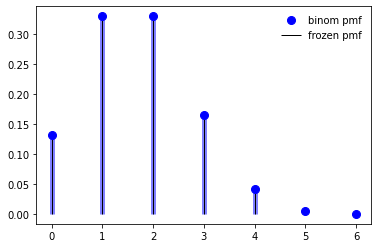

In [742]:
from scipy.stats import binom
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

n, p = 5, 1/3

x = np.arange(7)
              
ax.plot(x, binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)

rv = binom(n, p)

ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
          label='frozen pmf')
ax.legend(loc='best', frameon=False)


array([0.13168724, 0.32921811, 0.32921811, 0.16460905, 0.04115226,
       0.00411523, 0.        ])

In [686]:
names_dict = {v: k for k, v in names_dict.items()}

In [689]:
filename = '169-04.xml'

filename = filename.replace(filename.split('-')[0], names_dict[int(filename.split('-')[0])])

filename

'Raymond Pearce-04.xml'

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [163]:
docs_df = pd.DataFrame(docs, columns = ['raw_doc'])

In [165]:
#Clean document special characters

docs_df['clean_doc'] = docs_df['raw_doc'].str.replace("[^a-zA-Z#]", " ")

docs_df['clean_doc'] = docs_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
docs_df['clean_doc'] = docs_df['clean_doc'].apply(lambda x: x.lower())

In [172]:
#remove stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = docs_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(docs_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

docs_df['clean_doc'] = detokenized_doc

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= None, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(docs_df['clean_doc'])

# check shape of the document-term matrix
X.shape 

(788, 15263)

In [263]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=5, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)


5

In [278]:
X

<788x15263 sparse matrix of type '<class 'numpy.float64'>'
	with 156649 stored elements in Compressed Sparse Row format>

In [264]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i+1)+": ")
    for t in sorted_terms:
        print(t[0]+ "\n")


Topic 1: 
tablet

negative

daily

right

time

disease

cardiac

Topic 2: 
tablet

directed

capsule

days

acid

acetylsalicylic

problems

Topic 3: 
emergency

condition

tablet

department

resident

reviewed

physician

Topic 4: 
plasma

mmol

stat

absolute

negative

emergency

resident

Topic 5: 
daily

tablet

artery

coronary

cardiac

stenosis

graft



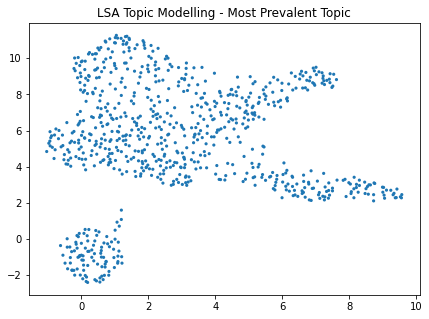

In [265]:
import umap.umap_ as umap
from matplotlib import cm

X_topics = svd_model.fit_transform(X)
embedding = umap.UMAP(n_neighbors=150, min_dist=0.5, random_state=12).fit_transform(X_topics)

plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
# c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.title('LSA Topic Modelling - Most Prevalent Topic')
plt.show()


In [201]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))

dataset.target

array([17,  0, 17, ...,  9,  4,  9])

In [222]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 20)

In [223]:
def get_pop_topic(row):
    

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.280894, 0.078907, 0.402329, 1.      ],
       [0.28229 , 0.145912, 0.46151 , 1.      ],
       [0.270595, 0.214069, 0.507052, 1.      ],
       [0.250425, 0.27429 , 0.533103, 1.      ],
       [0.223925, 0.334994, 0.548053, 1.      ],
       [0.19943 , 0.387607, 0.554642, 1.      ],
       [0.175841, 0.44129 , 0.557685, 1.      ],
       [0.15627 , 0.489624, 0.557936, 1.      ],
       [0.136408, 0.541173, 0.554483, 1.      ],
       [0.121831, 0.589055, 0.545623, 1.      ],
       [0.12478 , 0.640461, 0.527068, 1.      ],
       [0.162016, 0.687316, 0.499129, 1.      ],
       [0.239374, 0.735588, 0.455688, 1.      ],
       [0.335885, 0.777018, 0.402049, 1.      ],
       [0.458674, 0.816363, 0.329727, 1.      ],
       [0.585678, 0.846661, 0.249897, 1.      ],
       [0.730889, 0.871916, 0.156029, 1.      ],
       [0.866013, 0.889868, 0.095953, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

In [232]:
svd_model.components_.shape

(20, 15263)

# Knowledge Graph
##Steps
1. In order to build we need in a DataFrame: id for range(len(df)), 

In [258]:
import plotly.graph_objects as go

import networkx as nx

G = nx.random_geometric_graph(200, 0.125)

In [259]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [260]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append('# of connections: '+str(len(adjacencies[1])))

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [319]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) 
                            ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [398]:
# for x in node_app.layout.children:
#     print(x)

for x in fig.data:
    print([x])

[Scatter({
    'hoverinfo': 'none',
    'line': {'color': '#888', 'width': 0.5},
    'mode': 'lines',
    'x': [0.28555380810568487, 0.26455519125012283, None, ...,
          0.31773368521846834, 0.2544994577548728, None],
    'y': [0.9351778532209764, 0.891923640077982, None, ..., 0.7824296408736874,
          0.6766318468644562, None]
})]
[Scatter({
    'hoverinfo': 'text',
    'marker': {'color': [16, 7, 7, 7, 15, 6, 10, 9, 6, 13, 7, 7, 6, 6, 6, 9, 12,
                         7, 11, 7, 6, 10, 8, 6, 7, 6, 7, 10, 8, 10, 6, 14, 4, 9, 7,
                         7, 16, 10, 14, 4, 13, 10, 8, 4, 3, 8, 10, 9, 7, 8, 15, 10,
                         7, 7, 15, 10, 10, 5, 9, 15, 9, 13, 12, 14, 9, 11, 8, 5, 8,
                         7, 8, 7, 13, 10, 14, 7, 14, 5, 4, 7, 6, 13, 7, 9, 10, 7,
                         7, 3, 10, 14, 17, 12, 20, 7, 6, 9, 11, 7, 6, 13, 7, 7, 5,
                         14, 10, 7, 8, 4, 3, 5, 5, 6, 7, 10, 5, 9, 3, 7, 14, 9, 11,
                         8, 11, 6, 6, 1

In [399]:
import dash
import dash_cytoscape as cyto
import dash_html_components as html
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc

node_app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

node_app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape-two-nodes',
        layout={'name': 'preset'},
        style={'width': '100%', 'height': '400px'},
        elements = [
#             edge_trace, node_trace
            {'data': {'id': 'one', 'label': 'Node 1'}, 'position': {'x': 75, 'y': 75}},
            {'data': {'id': 'two', 'label': 'Node 2'}, 'position': {'x': 200, 'y': 200}},
            {'data': {'source': 'one', 'target': 'two'}}
        ]
    )
])

if __name__ == '__main__':
    node_app.run_server(mode = 'inline', port = 8991, debug=True)

In [363]:
import inflect

e = inflect.engine()

e.number_to_words(190898)


'one hundred and ninety thousand, eight hundred and ninety-eight'

In [397]:
node_app.layout.children[0]['x']

KeyError: 

In [346]:
ot = 74
players = [80, 77, 76, 80, 73, 76, 84, 78, 83, 80, 75, ot]

dt = 78
mlb = 78
cb = 78
defense = [84, 78, 81, 75, mlb, 75, 76, 80, 78, 80, 75, dt, 76, cb]

np.mean(defense)

78.0

In [353]:
p = 3/4
n = 10

term_2 = (n*p*(1-p))**2



term_1 = n**p*(1-p) + (n**2-n)*(p*(1-p))**2

ans = term_1 - term_2
ans

1.0542908129758732

In [410]:
changes = ['Dave +1', 'Fred +4', 'Brian -1']
c2 = [c.split() for c in changes]

In [422]:
changes['Dave' in changes]


'Dave +1'

In [423]:
leaders = ['John',
 'Brian',
 'Jim',
 'Dave',
 'Fred'
          ]

leaders[2]

'Jim'

In [474]:
leaders.index('Dave')+eval(changes[0].split()[1])
change_num = eval(change.split()[1])

for c in changes:
    c_num = eval(c.split()[1])
    
    if abs(change_num)==1:
        leaders.index('Dave'), leaders.index('Dave')+c_num = leaders.index('Dave')+c_num, leaders.index('Dave')
    elif abs(change_num) > 1:
        leaders.index('Dave')+c_num, [l for l in leaders if leaders.index('Dave')<leaders.index(l)<=leaders.index('Dave')+c_num or 
                                     leaders.index('Dave')>leaders.index(l)>=leaders.index('Dave')+c_num] = [
        l for l in leaders if leaders.index('Dave')<leaders.index(l)<=leaders.index('Dave')+c_num or 
                                     leaders.index('Dave')>leaders.index(l)>=leaders.index('Dave')+c_num], leaders.index('Dave')+c_num
        

SyntaxError: cannot assign to operator (<ipython-input-474-88dfed0ab62d>, line 10)

In [475]:
leaders = ['John',
 'Brian',
 'Jim',
 'Dave',
 'Fred']

changes = ['Dave +1', 'Fred +4', 'Brian -1']


new_leaders = []

pos = [0, 1, 2, 3, 4]
# +eval(c.split()[1])
 
for ix, name in enumerate(leaders):
    for c in changes:
        if name==c.split()[0]:
            del leaders[ix]
            ix_a = leaders.index()
            print(ix_a)
            new_leaders[ix-eval(c.split()[1])]==name
            new_leaders[leaders.index] = leaders
            print(leaders)
#             leaders = new_leaders
 
new_leaders

TypeError: index expected at least 1 argument, got 0

In [503]:
ls = list(range(5))
ls.pop(2)
leaders = ['John',
 'Brian',
 'Jim',
 'Dave',
 'Fred']
new_leaders = list(range(5))
print(leaders[2])
new_leaders[2] == leaders[2]

print(new_leaders)

for ix in ls:  
    new_leaders[ix] == leaders[ix]

new_leaders

Jim
[0, 1, 2, 3, 4]


[0, 1, 2, 3, 4]

In [507]:
def leaderboard_sort(lbd, changes):
#     lbd = lbd[:]
    for name,n in map(str.split, changes):
        print(name, n)
        n,i = int(n), lbd.index(name)
        lbd.pop(i)
        print(lbd)
        lbd.insert(i-n,name)
        print(lbd)
    return lbd

leaderboard_sort(leaders, changes)

Dave +1
['John', 'Brian', 'Jim', 'Fred']
['John', 'Brian', 'Dave', 'Jim', 'Fred']
Fred +4
['John', 'Brian', 'Dave', 'Jim']
['Fred', 'John', 'Brian', 'Dave', 'Jim']
Brian -1
['Fred', 'John', 'Dave', 'Jim']
['Fred', 'John', 'Dave', 'Brian', 'Jim']


['Fred', 'John', 'Dave', 'Brian', 'Jim']

In [626]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer().fit_transform(docs)

pairwise_similarity = tfidf * tfidf.T

pairwise_similarity.toarray()

def find_distances(sim_row):

    row = pairwise_similarity.toarray()[sim_row]
#     row = list(map(lambda x: 1-x, row))
    tups = zip([sim_row]*len(row), range(len(row)), 1000*row)
    tups = sorted(tups, 
                  key = lambda x: x[2], reverse=True
                 )
    return tups

new_pairs = find_distances(3)

3


In [632]:
len(new_pairs)

788

In [568]:
results = find_distances(3)

elements =  [{'data': {'id': row[0], 'label': row[0]},
         'position': {'x': 50, 'y': 50}} for row in results
                                ]
                       
elements

SyntaxError: closing parenthesis '}' does not match opening parenthesis '[' (<ipython-input-568-bf698efe4d0b>, line 3)

[['Dog', 'Dog', 1000.0], ['Cat', 'Dog', 254.13024630565053], ['Wolf', 'Dog', 36.47303495365963], ['Person', 'Dog', 13.397545684329591], ['Animal', 'Dog', 96.72980181425375], ['Cat', 'Cat', 1000.0], ['Wolf', 'Cat', 33.45706599866814], ['Person', 'Cat', 9.424385847603105], ['Animal', 'Cat', 75.53011124309671], ['Wolf', 'Wolf', 1000.0], ['Person', 'Wolf', 4.92891200563248], ['Animal', 'Wolf', 37.880057141438876], ['Person', 'Person', 1000.0], ['Animal', 'Person', 10.632115909826094], ['Animal', 'Animal', 1000.0]]


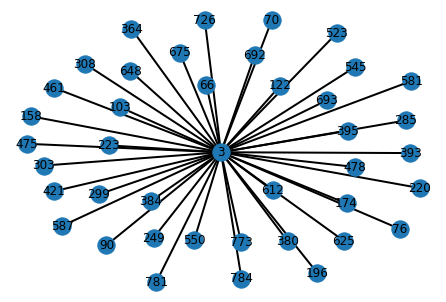

In [654]:
import networkx as nx
import matplotlib.pyplot as plt
G=nx.Graph(k_components = 700)

corr_data =([['Dog', 'Dog', 1.0],
       ['Cat', 'Dog', 0.8016854524612427],
       ['Wolf', 'Dog', 0.5206573009490967],
       ['Person', 'Dog', 0.3756750822067261],
       ['Animal', 'Dog', 0.6618534326553345],
       ['Cat', 'Cat', 1.0],
       ['Wolf', 'Cat', 0.5081626176834106],
       ['Person', 'Cat', 0.32475101947784424],
       ['Animal', 'Cat', 0.6260400414466858],
       ['Wolf', 'Wolf', 1.0],
       ['Person', 'Wolf', 0.23091702163219452],
       ['Animal', 'Wolf', 0.5261368751525879],
       ['Person', 'Person', 1.0],
       ['Animal', 'Person', 0.34220656752586365],
       ['Animal', 'Animal', 1.0]])

corr_data = [[x[0],x[1],1000**(x[2])] for x in corr_data]
print(corr_data)
existing_edges = {}

# def build_graph(w, lev):
#   if (lev > 5)  :
#       return
#   for z in corr_data:
#      ind=-1 
#      if z[0] == w:
#          ind=0
#          ind1=1
#      if z[1] == w:
#          ind ==1
#          ind1 =0

#      if ind == 0 or ind == 1:
#          if  str(w) + "_" + str(corr_data[ind1]) not in existing_edges :

#              G.add_node(str(corr_data[ind]))
#              existing_edges[str(w) + "_" + str(corr_data[ind1])] = 1;
#              G.add_edge(w,str(corr_data[ind1]))

#              build_graph(corr_data[ind1], lev+1)


existing_nodes = {}
def build_graph_for_all(corr_data):
    count=0
    for d in corr_data:
        if (count > 40) :
            return
        if  d[0] not in existing_edges :
             G.add_node(str(d[0]))
        if  d[1] not in existing_edges :     
             G.add_node(str(d[1]))
        G.add_weighted_edges_from([[str(d[0]), str(d[1]),d[2]]])     
        count += 1


build_graph_for_all(new_pairs)

pos = nx.spring_layout(G,weight='weight')
nx.draw(G,width=2, with_labels=True)


In [662]:
G.number_of_edges()

41

In [670]:
import shorttext
import numpy as np
import pandas as pd
from stemming.porter2 import stem
 
import re

pipeline = [lambda s: re.sub('[^\w\s]', '', s),
            lambda s: re.sub('[\d]', '', s),
            lambda s: s.lower(),
            lambda s: ' '.join(map(stem, shorttext.utils.tokenize(s)))
 ]
txtpreprocessor = shorttext.utils.text_preprocessor(pipeline)

docids = range(len(docs))   # defining document IDs
corpus = [txtpreprocessor(doc).split(' ') for doc in docs]

dtm = shorttext.utils.DocumentTermMatrix(corpus, docids=docids, tfidf=False)



In [675]:
dtm.get_token_occurences(stem('doctor'))


{6: 1.0,
 8: 1.0,
 124: 1.0,
 191: 1.0,
 204: 1.0,
 236: 1.0,
 250: 1.0,
 303: 1.0,
 308: 1.0,
 326: 1.0,
 404: 1.0,
 407: 1.0,
 412: 1.0,
 425: 2.0,
 448: 1.0,
 478: 1.0,
 531: 1.0,
 532: 1.0,
 550: 1.0,
 563: 1.0,
 573: 2.0,
 586: 1.0,
 637: 1.0,
 644: 1.0,
 652: 1.0,
 689: 1.0,
 717: 1.0,
 725: 1.0,
 736: 1.0,
 738: 1.0,
 749: 1.0,
 761: 1.0,
 781: 2.0}

In [608]:
def pairwise_coords(ps_array):
    ps_coords = []
    for i in range(ps_array.shape[0]):
        for j in range(ps_array.shape[1]):
            ps_coords.append([i, j, ps[i, j]])
            
    return ps_coords

In [645]:
help(nx.spring_layout)

Help on function fruchterman_reingold_layout in module networkx.drawing.layout:

fruchterman_reingold_layout(G, k=None, pos=None, fixed=None, iterations=50, threshold=0.0001, weight='weight', scale=1, center=None, dim=2, seed=None)
    Position nodes using Fruchterman-Reingold force-directed algorithm.
    
    The algorithm simulates a force-directed representation of the network
    treating edges as springs holding nodes close, while treating nodes
    as repelling objects, sometimes called an anti-gravity force.
    Simulation continues until the positions are close to an equilibrium.
    
    There are some hard-coded values: minimal distance between
    nodes (0.01) and "temperature" of 0.1 to ensure nodes don't fly away.
    During the simulation, `k` helps determine the distance between nodes,
    though `scale` and `center` determine the size and place after
    rescaling occurs at the end of the simulation.
    
    Fixing some nodes doesn't allow them to move in the simulati

In [663]:
docs[0]

"\n\n\nRecord date: 2062-03-27\n\nHematology Clinic Progress Note \n\nFellow: Inge Logan, MD\nAttending:  Cole Morgan, MD, PhD\n\nDate of visit:  March 27, 2062\n\nDiagnosis:  Mr. Goins is a 27 yoM with thrombocytosis here for interval follow-up on hydrea.\n\nHematologic History:\nMr. Goins is a 27 yo male with history of type I DM formally without regular medical care who was  visiting family in Maryland and had sudden witnessed seizure activity in late August.  At the time, blood sugar was >500.  Upon initial arrival to the ER in Maryland, he has BP 248/146; plt count was in 800's.  The patient was intubated, treated for HTN with labetolol and placed on IV insulin and dilantin  and transferred to BMH for further care.  \n\nAt BMH, brain MRI showed several small areas of infarct read as concerning for embolic CVA.  Embolic work-up included an echo which showed no vegetations, no PFO, NL EF with LVH; TEE without vegetations as well.  LP was done and sent for HSV which was negative.  He